Implementation of the LangGraph ReAct Function Calling Pattern

In [80]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv('OPENWEATHERMAP_API_KEY')

In [5]:
from langchain_openai import ChatOpenAI
#Initializing the language model
llm = ChatOpenAI(model="gpt-4o")

In [7]:
llm.invoke("Best places to visit in Tamilnadu?").content

'Tamil Nadu, located in the southern part of India, is renowned for its rich cultural heritage, historical landmarks, and stunning natural beauty. Here are some of the best places to visit in Tamil Nadu:\n\n1. **Chennai**: The capital city is a bustling metropolis known for its cultural landmarks, beaches (like Marina Beach), and historical sites. Don\'t miss the Kapaleeshwarar Temple and Fort St. George.\n\n2. **Mahabalipuram**: Famous for its UNESCO World Heritage-listed group of monuments, including rock-cut temples and the Shore Temple. It\'s also known for its beautiful beaches.\n\n3. **Kanchipuram**: Known as the "City of Thousand Temples," it\'s famous for its ancient temples and silk sarees.\n\n4. **Pondicherry**: Although technically a Union Territory, it is surrounded by Tamil Nadu. Known for its French colonial architecture, serene beaches, and the Auroville community.\n\n5. **Madurai**: The city is home to the magnificent Meenakshi Amman Temple, a masterpiece of Dravidian a

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b

In [30]:
from langchain_community.tools import TavilySearchResults

search = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

In [31]:
search.invoke('How old is brad pitt?')

[{'url': 'https://screenrant.com/wolfs-movie-brad-pitt-george-clooney-ages/',
  'content': "At the time of filming in early 2023, Brad Pitt was 59 years old, having been born on December 18, 1963. Wolfs began production in late 2021, but it wasn't until early 2023 that the film started filming scenes in New York City, just a month after his birthday.Pitt had just finished doing press for his late 2022 movie, Babylon, which was met with a divisive response, making his long-awaited"},
 {'url': 'https://nypost.com/2023/12/20/entertainment/brad-pitts-60th-birthday-paris-photos-with-girlfriend-ines-de-ramon/',
  'content': 'Brad Pitt rang in his six-decade milestone in a big way — twice! Pitt celebrated his 60th birthday on Monday, along with friends and his girlfriend, Ines de Ramon, 33, with "low key'},
 {'url': 'https://www.famousbirthdays.com/people/brad-pitt.html',
  'content': 'Brad Pitt - Age, Family, Bio | Famous Birthdays popular trending video trivia random Movie Actor Hollywood s

In [32]:
tools = [add, multiply, divide, search]

llm_with_tools = llm.bind_tools(tools)

In [33]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [34]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

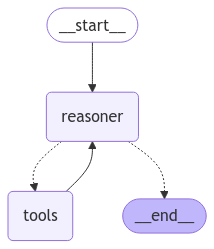

In [35]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
messages = [HumanMessage(content="What is 2 times Brad Pitt's age?")]
messages = react_graph.invoke({"messages": messages})
#Displaying the response
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_knLsn0JokDuBeVubRaMLrki8)
 Call ID: call_knLsn0JokDuBeVubRaMLrki8
  Args:
    query: Brad Pitt's age
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.hellomagazine.com/celebrities/736816/brad-pitt-birthday-amid-estrangement-from-kids/", "content": "Brad Pitt's latest birthday marks the third he is celebrating since starting to date girlfriend Inés de Ramón. The F1 actor celebrated his 61st birthday this December 18."}, {"url": "https://www.famousbirthdays.com/people/brad-pitt.html", "content": "Brad Pitt - Age, Family, Bio | Famous Birthdays popular trending video trivia random Movie Actor Hollywood star who played lead roles in the films Moneyball, Fight Club,

### Adding a Custom Tool for Stock Prices

In [40]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']


In [41]:
get_stock_price("AAPL")

249.79

In [87]:
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from langchain_core.tools import Tool

# Initialize the weather API wrapper
weather_api = OpenWeatherMapAPIWrapper()

# Define a callable weather tool
def get_weather(location: str) -> str:
    """Fetch weather information for a given location."""
    return weather_api.run(location)

# Define the tool in the required format
weather_tool = Tool(
    name="weather",
    description="Get the current weather for a given location. Input should be a string representing the location.",
    func=get_weather,
)

In [88]:
weather_data = weather_tool.run("London,GB")
print(weather_data)

In London,GB, the current weather is as follows:
Detailed status: broken clouds
Wind speed: 8.75 m/s, direction: 270°
Humidity: 71%
Temperature: 
  - Current: 6.08°C
  - High: 7.22°C
  - Low: 5.28°C
  - Feels like: 1.36°C
Rain: {}
Heat index: None
Cloud cover: 75%


### Define the Reasoner Function

##### Modifying the reasoner function to accommodate stock-related queries. The function will check the type of query and determine whether to use the stock price tool:

In [85]:
from langchain_core.messages import HumanMessage, SystemMessage
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message indicating the assistant's capabilities
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool, the weather tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    # Invoke the LLM with the messages
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [89]:
# Update the tools list to include the stock price function
tools = [add, multiply, divide, search, get_stock_price, weather_tool]
# Re-initialize the language model with the updated tools
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [90]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [91]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode
# Graph
workflow = StateGraph(GraphState)
# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) 
# Add Edges
workflow.add_edge(START, "reasoner")
workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

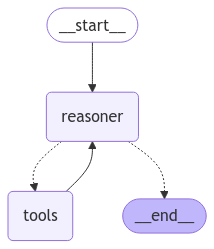

In [92]:
# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [93]:
response = react_graph.invoke({"query": "What is the weather in chennai?", "messages": []})
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

In Chennai, the current weather is misty, with a wind speed of 4.12 m/s coming from the direction of 30°. The humidity level is at 84%. The temperature is currently 26.5°C, with a high of 26.99°C and a low of 26.11°C. It feels like 26.5°C, and the cloud cover is at 40%. There is no rain at the moment.


In [51]:
response = react_graph.invoke({"query": "What is the stock price of ITC?", "messages": []})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of ITC?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_bugYhEjnuKwe6tQXzJXUuwFU)
 Call ID: call_bugYhEjnuKwe6tQXzJXUuwFU
  Args:
    ticker: ITC
================================= Tool Message =================================
Name: get_stock_price

Error: KeyError('previousClose')
 Please fix your mistakes.
================================ Human Message =================================

What is the stock price of ITC?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_CDzrVlAdfJNxeDUEraGo3Z5W)
 Call ID: call_CDzrVlAdfJNxeDUEraGo3Z5W
  Args:
    ticker: ITC
================================= Tool Message =================================
Name: get_stock_price

Error: KeyError('previousClose')
 Please fix your mistakes.
==============================

In [52]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_fzeqmgu8Km4b7XZuDkf8J5lf)
 Call ID: call_fzeqmgu8Km4b7XZuDkf8J5lf
  Args:
    query: Jensen Huang CEO company
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Jensen_Huang", "content": "In 2022 Huang donated US$50 million to his alma mater, Oregon State University, as a portion of a US$200 million donation towards the creation of a supercomputing institute on campus.[10]\nHuang gave his other alma mater Stanford University US$30 million to build the Jen-Hsun Huang School of Engineering Center.[11] Contents\nJensen Huang\nJen-Hsun \"Jensen\" Huang (Chinese: 黃仁勳; pinyin: Huáng Rénxūn; Pe̍h-ōe-jī: N̂g Jîn-hun; b